# Install Dependency

In [ ]:
!pip install torchmetrics

# Download Dataset

In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99%|██████████████████████████████████████▌| 2.27G/2.29G [00:09<00:00, 243MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:09<00:00, 270MB/s]


In [ ]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Library Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # for confusion matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

In [ ]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


# Custom Dataset for Pneumonia Dataset

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label in ['NORMAL', 'PNEUMONIA']:
            class_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(0 if label == 'NORMAL' else 1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms, Datasets and DataLoaders

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # Data Augmentation
    transforms.RandomRotation(10), # Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = PneumoniaDataset(root_dir='/kaggle/working/chest_xray/train', transform=train_transform)
val_dataset = PneumoniaDataset(root_dir='/kaggle/working/chest_xray/val', transform=val_test_transform)
test_dataset = PneumoniaDataset(root_dir='/kaggle/working/chest_xray/test', transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Data Exploration

In [ ]:
def show_sample_images(dataset, num_samples=5, without_transform=True):
    fig, axes = plt.subplots(1, num_samples, figsize=(15,3))
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        if without_transform:
            transform = transforms.ToTensor()
            img = transform(img)
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title('Normal' if label==0 else 'Pneumonia')
        axes[i].axis('off')
    plt.show()

In [ ]:
def class_distribution(dataset, name):
    labels = [label for _, label in dataset]
    num_normal = sum(1 for label in labels if label == 0)
    num_pneumonia = sum(1 for label in labels if label == 1)
    print('------------------------------')
    print(f"{name} set: Normal: {num_normal} | Pneumonia: {num_pneumonia}")


Displaying sample images from training set without transform
--------------------------------------------------------------


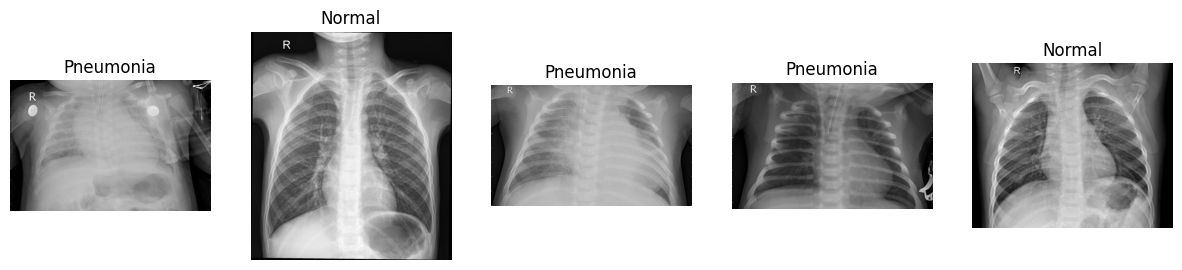

In [ ]:
train_set_show = PneumoniaDataset(root_dir='/kaggle/working/chest_xray/train')
print('')
print('Displaying sample images from training set without transform')
print('--------------------------------------------------------------')

show_sample_images(train_set_show)


Displaying sample images from training set with transform
--------------------------------------------------------------


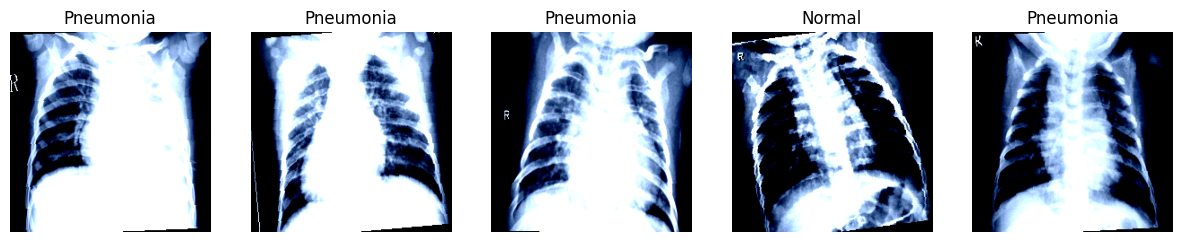

In [ ]:
train_set_show = PneumoniaDataset(root_dir='/kaggle/working/chest_xray/train', transform= train_transform)
# print(torchvision.transforms.functional.to_pil_image(train_set_show, mode=None))
# train_set_show = torchvision.transforms.functional.to_pil_image(train_set_show, mode=None)
print('')
print('Displaying sample images from training set with transform')
print('--------------------------------------------------------------')

show_sample_images(train_set_show, without_transform=False)

In [ ]:
class_distribution(train_dataset, 'Train')
class_distribution(val_dataset, 'Validation')
class_distribution(test_dataset, 'Test')

------------------------------
Train set: Normal: 1341 | Pneumonia: 3875
------------------------------
Validation set: Normal: 8 | Pneumonia: 8
------------------------------
Test set: Normal: 234 | Pneumonia: 390


# Model Definition

In [ ]:
model = torchvision.models.efficientnet_b0(pretrained=True)
# (classifier): Sequential(
#     (0): Dropout(p=0.2, inplace=True)
#     (1): Linear(in_features=1280, out_features=1000, bias=True)
#   )

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=2)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 176MB/s]


In [ ]:
# Transfer Model to Device
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000

In [ ]:
print(f"Model has {count_parameters(model)} million parameters")

Model has 4.01011 million parameters


# Define Criterion and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Tensorboard

In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 129 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (82.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 127400 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tensorboard --version

2025-02-24 17:05:59.051023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-24 17:05:59.070798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-24 17:05:59.076795: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1740416761.788614     150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740416762.364607     150 cuda_executor.cc:1015] succ

In [ ]:
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar xf ./ngrok-v3-stable-linux-amd64.tgz -C /usr/local/bin

--2025-02-24 17:06:03--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 35.71.179.82, 75.2.60.68, 13.248.244.96, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.71.179.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14817368 (14M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz’

ngrok-v3-stable-lin 100%[===================>]  14.13M  16.8MB/s    in 0.8s    

2025-02-24 17:06:08 (16.8 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz’ saved [14817368/14817368]



In [ ]:
!ngrok authtoken <your-ngrok-token>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os
import multiprocessing

pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir ./runs/ --load_fast=false --host 0.0.0.0 --port 6006 &",
                        "/usr/local/bin/ngrok http 6006 &"
                        ]]

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://cd0b-35-197-123-220.ngrok-free.app


# Define AverageMeter Class

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Define Checkpoint Class

In [ ]:
class Checkpoint(object):
    def __init__(self):
        self.best_acc = 0.
        self.folder = 'checkpoint'
        os.makedirs(self.folder, exist_ok=True)

    def save(self, model, acc, filename, epoch=-1):
        if acc > self.best_acc:
            print('Saving Checkpoint...')
            state={
                'model': model.state_dict(),
                'acc' : acc,
                'epoch' : epoch
            }
            path = os.path.join(os.path.abspath(self.folder), filename + '.pth')
            torch.save(state, path)
            self.best_acc = acc

    def load(self, model):
        path = os.path.join(os.path.abspath(self.folder), 'ckpt.pth')
        if os.path.exists(path):
            print(f'Loading checkpint from {path} ...')
            checkpoint = torch.load(path)
            model.load_state_dict(checkpoint['model'])
            return checkpoint['acc'], checkpoint['epoch']
        else:
            print(f'No checkpint found at {path}.')
            return 0.0, -1

# Define EarlyStopping Class

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Train, Val and Test Functions

In [ ]:
def train(epoch, writer):
    model.train()

    loss_meter = AverageMeter()
    acc_meter = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
    precision_meter = torchmetrics.Precision(task="multiclass", num_classes=2).to(device)
    recall_meter = torchmetrics.Recall(task="multiclass", num_classes=2).to(device)
    f1_meter = torchmetrics.F1Score(task="multiclass", num_classes=2).to(device)

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item())
        preds = outputs.softmax(dim=-1)
        acc_meter(preds, targets)
        precision_meter(preds, targets)
        recall_meter(preds, targets)
        f1_meter(preds, targets)

    acc = acc_meter.compute().item()
    precision = precision_meter.compute().item()
    recall = recall_meter.compute().item()
    f1 = f1_meter.compute().item()

    writer.add_scalar('Loss/Train', loss_meter.avg, epoch)
    writer.add_scalar('Acc/Train', acc, epoch)
    writer.add_scalar('Precision/Train', precision, epoch)
    writer.add_scalar('Recall/Train', recall, epoch)
    writer.add_scalar('F1/Train', f1, epoch)
    print(f'Train --> Epoch: {epoch} | Loss: {loss_meter.avg:.4f} | Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')
    return loss_meter.avg, acc

def val(epoch, writer):
    model.eval()

    loss_meter = AverageMeter()
    acc_meter = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
    precision_meter = torchmetrics.Precision(task="multiclass", num_classes=2).to(device)
    recall_meter = torchmetrics.Recall(task="multiclass", num_classes=2).to(device)
    f1_meter = torchmetrics.F1Score(task="multiclass", num_classes=2).to(device)

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss_meter.update(loss.item())
            preds = outputs.softmax(dim=-1)
            acc_meter(preds, targets)
            precision_meter(preds, targets)
            recall_meter(preds, targets)
            f1_meter(preds, targets)

        acc = acc_meter.compute().item()
        precision = precision_meter.compute().item()
        recall = recall_meter.compute().item()
        f1 = f1_meter.compute().item()

        writer.add_scalar('Loss/Val', loss_meter.avg, epoch)
        writer.add_scalar('Acc/Val', acc, epoch)
        writer.add_scalar('Precision/Val', precision, epoch)
        writer.add_scalar('Recall/Val', recall, epoch)
        writer.add_scalar('F1/Val', f1, epoch)
        print(f'Val --> Epoch: {epoch} | Loss: {loss_meter.avg:.4f} | Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')
        return loss_meter.avg, acc


def test(epoch, writer, checkpoint):
    model.eval()

    loss_meter = AverageMeter()
    acc_meter = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
    precision_meter = torchmetrics.Precision(task="multiclass", num_classes=2).to(device)
    recall_meter = torchmetrics.Recall(task="multiclass", num_classes=2).to(device)
    f1_meter = torchmetrics.F1Score(task="multiclass", num_classes=2).to(device)
    all_preds, all_targets = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss_meter.update(loss.item())
            preds = outputs.softmax(dim=-1)
            acc_meter(preds, targets)
            precision_meter(preds, targets)
            recall_meter(preds, targets)
            f1_meter(preds, targets)
            all_preds.extend(preds.argmax(dim=-1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        acc = acc_meter.compute().item()
        precision = precision_meter.compute().item()
        recall = recall_meter.compute().item()
        f1 = f1_meter.compute().item()

        writer.add_scalar('Loss/Test', loss_meter.avg, epoch)
        writer.add_scalar('Acc/Test', acc, epoch)
        writer.add_scalar('Precision/Test', precision, epoch)
        writer.add_scalar('Recall/Test', recall, epoch)
        writer.add_scalar('F1/Test', f1, epoch)
        print(f'Test --> Loss: {loss_meter.avg:.4f} | Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')

        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['normal', 'Pneumonia'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix.png')
        plt.show()

        return loss_meter.avg, acc, precision, recall, f1

In [ ]:
writer = SummaryWriter()
checkpoint = Checkpoint()
early_stopping = EarlyStopping(patience=5)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs+1):
    train_loss, train_acc = train(epoch, writer)
    val_loss, val_acc = val(epoch, writer)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    checkpoint.save(model, val_acc, "EfficientNet-b0", epoch)
    scheduler.step(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Train --> Epoch: 0 | Loss: 0.1345 | Accuracy: 0.9479 | Precision: 0.9479 | Recall: 0.9479 | F1: 0.9479
Val --> Epoch: 0 | Loss: 0.7126 | Accuracy: 0.5625 | Precision: 0.5625 | Recall: 0.5625 | F1: 0.5625
Saving Checkpoint...
Train --> Epoch: 1 | Loss: 0.0597 | Accuracy: 0.9783 | Precision: 0.9783 | Recall: 0.9783 | F1: 0.9783
Val --> Epoch: 1 | Loss: 0.4014 | Accuracy: 0.7500 | Precision: 0.7500 | Recall: 0.7500 | F1: 0.7500
Saving Checkpoint...
Train --> Epoch: 2 | Loss: 0.0442 | Accuracy: 0.9822 | Precision: 0.9822 | Recall: 0.9822 | F1: 0.9822
Val --> Epoch: 2 | Loss: 0.1088 | Accuracy: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | F1: 1.0000
Saving Checkpoint...
Train --> Epoch: 3 | Loss: 0.0448 | Accuracy: 0.9833 | Precision: 0.9833 | Recall: 0.9833 | F1: 0.9833
Val --> Epoch: 3 | Loss: 0.0762 | Accuracy: 0.9375 | Precision: 0.9375 | Recall: 0.9375 | F1: 0.9375
Train --> Epoch: 4 | Loss: 0.0290 | Accuracy: 0.9885 | Precision: 0.9885 | Recall: 0.9885 | F1: 0.9885
Val --> Epoch: 4 |

# Loading the best model and running the test

No checkpint found at /kaggle/working/checkpoint/ckpt.pth.
Best validation accuracy: 0.0 at epoch -1
Starting Test...
Test --> Loss: 1.3097 | Accuracy: 0.7949 | Precision: 0.7949 | Recall: 0.7949 | F1: 0.7949


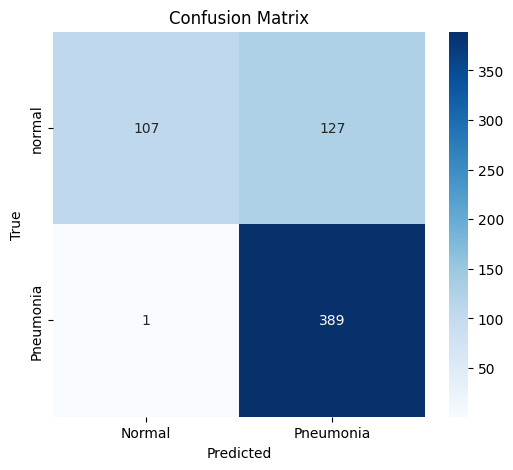

In [ ]:
best_acc, best_epoch = checkpoint.load(model)
print(f"Best validation accuracy: {best_acc:.4} at epoch {best_epoch}")
print("Starting Test...")
avg_loss_meter, acc, precision, recall, f1 = test(best_epoch, writer, checkpoint)

# Plot Loss and Accuracy

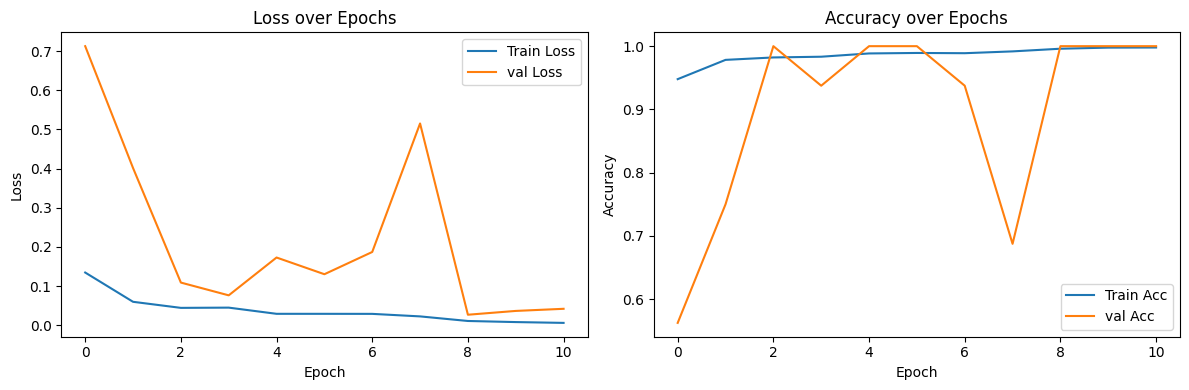

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

writer.close()

# Save test results

In [ ]:
with open('test_results.txt', 'w') as f:
    f.write(f"Best Validation Accuracy: {best_acc:.4f} at epoch {best_epoch}\n\n")
    f.write("Test Metrics\n")
    f.write(f"Loss: {avg_loss_meter:.4f}\n")
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1: {f1:.4f}\n")
    print("Results Saved")

Results Saved
